Pneumonia - ML in healthcare - Data Exploration
===
Inspiration from:

*  Kaggle Pneumonia colab: https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
import torch.nn.functional as F
# import param

In [11]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('~/untracked_data/chest_data/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# import sklearn as sk
# import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [6]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

In [7]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=5 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="validation",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
# pn.Param(CustomExample.param, widgets={
#     'select_string': {'type': pn.widgets.RadioButtonGroup, 'button_type': 'primary'},
#     'select_number': pn.widgets.DiscretePlayer}
# )
base = NotebookParams()

# Import Data

In [14]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../../../untracked_data/chest_data/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../../untracked_data/chest_data/chest_xray/.DS_Store
../../../untracked_data/chest_data/chest_xray/test/.DS_Store
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0256-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0374-0001-0002.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0286-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0370-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0333-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/IM-0007-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/IM-0089-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0300-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0328-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0237-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NOR

In [18]:
import cv2

In [44]:
label = 'PNEUMONIA'
labels.index(label)

0

In [29]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
		data = [] 
		for label in labels: 
				path = os.path.join(data_dir, label)
				class_num = labels.index(label)
				for img in os.listdir(path):
						try:
								img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
								resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
								data.append([resized_arr, class_num])
						except Exception as e:
								print(e)
		# return np.array(data)
		return data

In [27]:
img = img_list[0]
cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

array([[ 0,  0,  0, ...,  1,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       ...,
       [ 1,  0, 33, ...,  0,  0,  0],
       [ 3,  0, 30, ...,  0,  0,  0],
       [ 4,  0, 29, ...,  0,  0,  0]], dtype=uint8)

In [ ]:
train = get_training_data('../../../untracked_data/chest_data/chest_xray/train')
test = get_training_data('../../../untracked_data/chest_data/chest_xray/test')

In [36]:
test[8]

[array([[ 56,  59,  58, ..., 220, 219, 219],
        [ 58,  58,  57, ..., 217, 221, 221],
        [ 58,  58,  58, ..., 217, 221, 222],
        ...,
        [ 25,  22,  21, ...,  23,  29,  30],
        [ 22,  23,  20, ...,  22,  27,  30],
        [ 22,  23,  21, ...,  21,  26,  29]], dtype=uint8),
 0]

# Data Visualization & Preprocessing

<Axes: xlabel='count'>

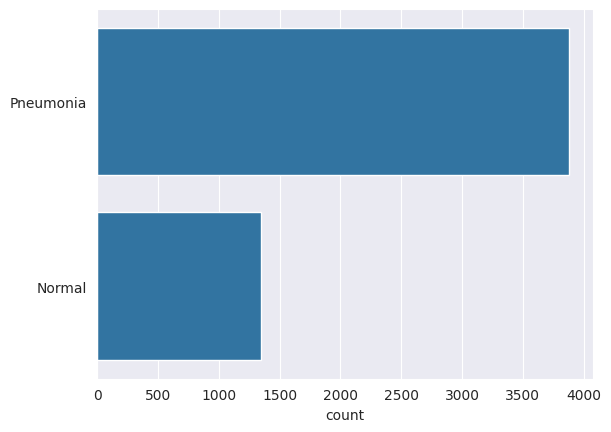

In [45]:
list_all_labels = []
for i in train:
    if(i[1] == 0):
        list_all_labels.append("Pneumonia")
    else:
        list_all_labels.append("Normal")
sns.set_style('darkgrid')
sns.countplot(list_all_labels) 

In [48]:
pd.Series(list_all_labels).value_counts()['Pneumonia']

3883

In [50]:
set(list_all_labels)

{'Normal', 'Pneumonia'}

In [56]:
import random

In [58]:
count_labels = pd.Series(list_all_labels).value_counts()
index_pneumonia = [i for i, n in enumerate(list_all_labels) if n == 'Pneumonia']
index_normal = [i for i, n in enumerate(list_all_labels) if n == 'Normal']
index_outcomes = {
		'Pneumonia': index_pneumonia,
		'Normal': index_normal,
}
for col_idx, outcome in enumerate(list(set(list_all_labels))):
		n_imgs = count_labels[outcome]
		items_to_plot = random.sample(range(0,n_imgs), 3)

In [59]:
items_to_plot

[522, 653, 829]

In [66]:
outcome = 'Pneumonia'
item = 0
train[index_outcomes[outcome][items_to_plot[0]]]

[array([[ 32,  41,  45, ..., 194, 188, 194],
        [ 36,  44,  48, ..., 187, 188, 189],
        [ 41,  48,  51, ..., 187, 183, 191],
        ...,
        [  3,   1,  32, ...,  30,   1,   3],
        [  3,   1,  32, ...,  30,   0,   7],
        [  3,   2,  32, ...,  30,   0,   7]], dtype=uint8),
 0]

In [65]:
items_to_plot[0]

522

In [73]:
nb = 3694
train[nb]

[array([[37, 44, 48, ..., 20, 38, 17],
        [40, 45, 50, ..., 48, 30, 41],
        [43, 47, 53, ..., 55, 45, 31],
        ...,
        [36, 44, 58, ..., 22, 31, 36],
        [36, 41, 57, ..., 23, 35, 37],
        [37, 44, 58, ..., 27, 33, 39]], dtype=uint8),
 0]

In [74]:
import graph as gr
reload(gr)
import graph as gr

items_to_plot are [3113, 2557, 1476, 915, 529, 1546]
items_to_plot are [1088, 436, 1086, 674, 721, 195]


/home/pinolej/eth/healthcare/chest/graph.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


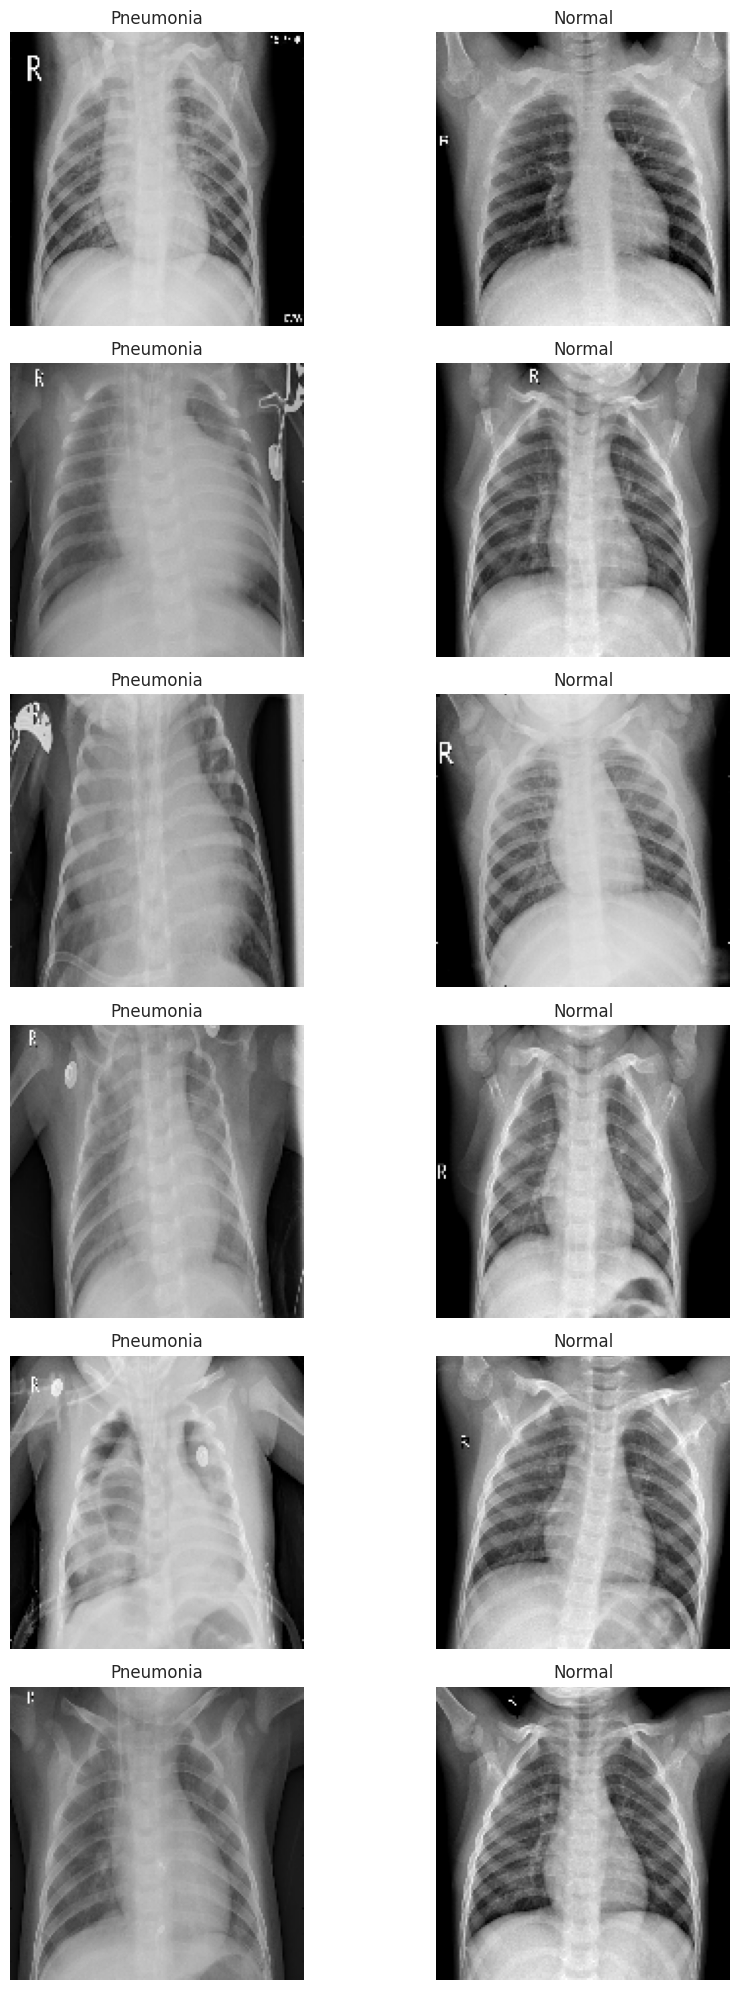

In [78]:
gr.images_subplots(
    img_data=train,
    ncols=2,
		nrows=6,
		figsize=(10,20),
		list_all_labels=list_all_labels,
    labels=list(set(list_all_labels)),
)

# CNN

In [115]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## Features Preprocessing

In [91]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'0cef7850-4994-401a-85b1-9ef45881a98b': {'version…

In [104]:
# Split train into train and val
n_train_initial = len(train)
n_test = math.ceil(base.test_size * n_train_initial)
idx_for_test_elements = random.sample(range(0,n_train_initial), n_test)
train_train = [train[i] for i in range(n_train_initial) if i not in idx_for_test_elements]
train_val = [train[i] for i in range(n_train_initial) if i in idx_for_test_elements]

5232
1047
1047
4185
1047
5232


In [105]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in train_val:
    x_val.append(feature)
    y_val.append(label)

In [106]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [107]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [116]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [117]:
import py_lib as lib
reload(lib)
import py_lib as lib

## Working with the class imbalance

In [118]:
# # From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
# class_counts = np.bincount(y_train)
# num_classes = len(class_counts)
# total_samples = len(y_train)

# class_weights = []
# for count in class_counts:
#     weight = 1 / (count / total_samples)
#     class_weights.append(weight)

# class_weights_tensor = torch.FloatTensor(class_weights)

In [119]:
# class_weights

## Model Building

In [120]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [121]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/home/pinolej/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

## Training

In [123]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [127]:
history = model.fit(
	datagen.flow(
		x_train,
		y_train,
		batch_size = 32,
	) ,
	epochs = 12 ,
	validation_data = datagen.flow(x_val, y_val),
	callbacks = [learning_rate_reduction],
	verbose=0,
	)

/home/pinolej/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 7: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.


In [131]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
# save_model(model, "model_second_save.h5")
# save model and architecture to single file
model.save("cnn_v0.h5")
model.save('cnn_v0.keras')
print("Saved model to disk")


Saved model to disk


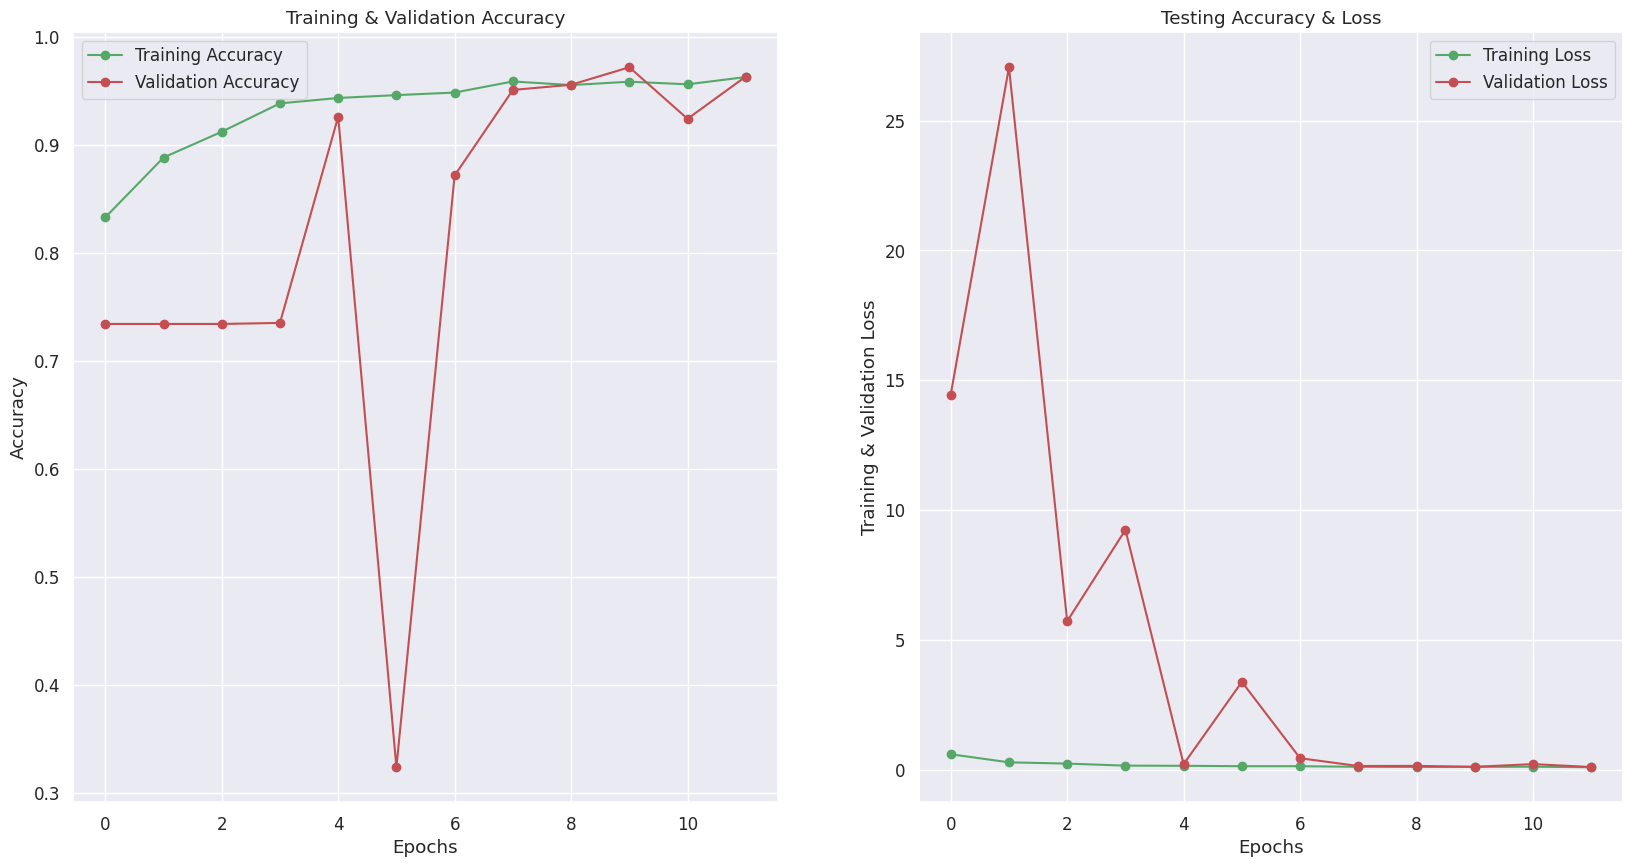

In [160]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# # load model
# model = load_model('model.h5')

# Evaluation

<Axes: xlabel='count'>

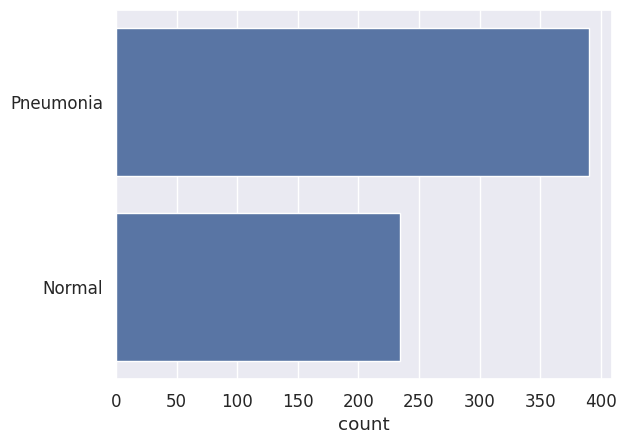

In [162]:
list_all_labels_test = []
for i in test:
    if(i[1] == 0):
        list_all_labels_test.append("Pneumonia")
    else:
        list_all_labels_test.append("Normal")
sns.set_style('darkgrid')
sns.countplot(list_all_labels_test) 

In [161]:
results = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print("Loss of the model is - " , results[0])
print("Accuracy of the model is - " , results[1]*100 , "%")

Loss of the model is -  0.2990112900733948
Accuracy of the model is -  87.5 %


In [136]:
print("test loss, test acc:", results)

test loss, test acc: [0.2990112900733948, 0.875]


## Predictions performances

In [142]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
predictions_proba = model.predict(x_test)

Generate a prediction


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step


<Axes: >

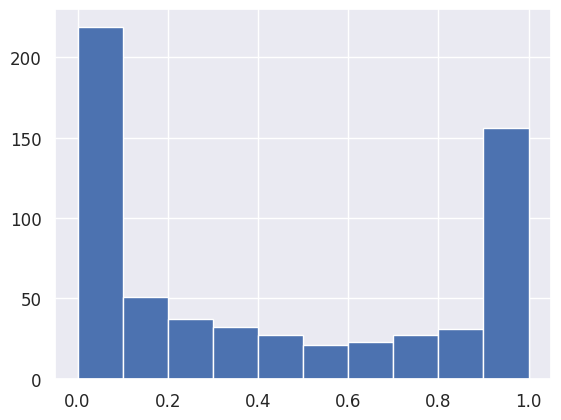

In [165]:
pd.Series(data=predictions_proba.flatten(), name='probability of xray being normal').hist()

In [168]:
predictions_proba.shape

(624, 1)

In [171]:
predictions = np.copy(predictions_proba)
predictions[predictions <= 0.5] = 0.
predictions[predictions > 0.5] = 1.

<Axes: >

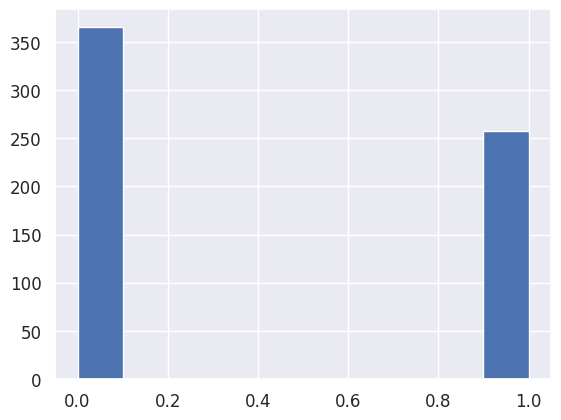

In [172]:
pd.Series(data=predictions.flatten(), name='predicted_classes').hist()

In [173]:
cm = confusion_matrix(y_test,predictions)
cm

array([[339,  51],
       [ 27, 207]])

In [174]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

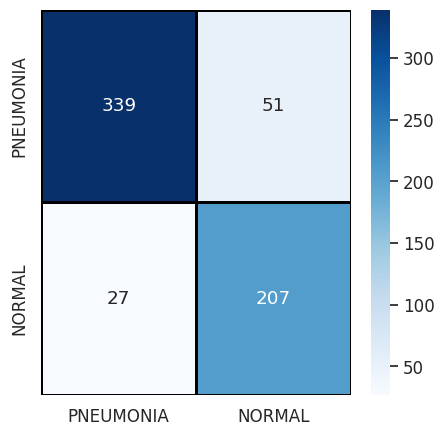

In [175]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [182]:
y_true = torch.from_numpy(y_test)
y_pred_round = predictions.flatten()
y_pred_round_tensor = torch.from_numpy(predictions).flatten()
y_pred = predictions_proba

In [183]:
y_true.shape

torch.Size([624])

In [184]:
y_pred_round_tensor.shape

torch.Size([624])

In [185]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,87.5%,87.7%,84.1%


<style type="text/css">
</style>
<table id="T_4e833">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_4e833_level0_col0" class="col_heading level0 col0" >Accuracy</th>
      <th id="T_4e833_level0_col1" class="col_heading level0 col1" >Balanced Accuracy</th>
      <th id="T_4e833_level0_col2" class="col_heading level0 col2" >F1 Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_4e833_level0_row0" class="row_heading level0 row0" >metrics</th>
      <td id="T_4e833_row0_col0" class="data row0 col0" >87.5%</td>
      <td id="T_4e833_row0_col1" class="data row0 col1" >87.7%</td>
      <td id="T_4e833_row0_col2" class="data row0 col2" >84.1%</td>
    </tr>
  </tbody>
</table>


In [ ]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,87.5%,87.7%,84.1%


Text(0.5, 1.0, 'Confusion Matrix Pneumonia Prediction - CNN')

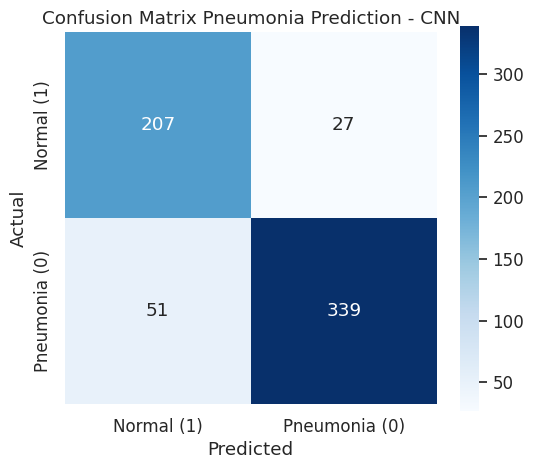

In [217]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['Pneumonia (0)', 'Normal (1)'],
    yticklabels=['Pneumonia (0)', 'Normal (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix Pneumonia Prediction - CNN')

In [188]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/chest/graph.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/chest/graph.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


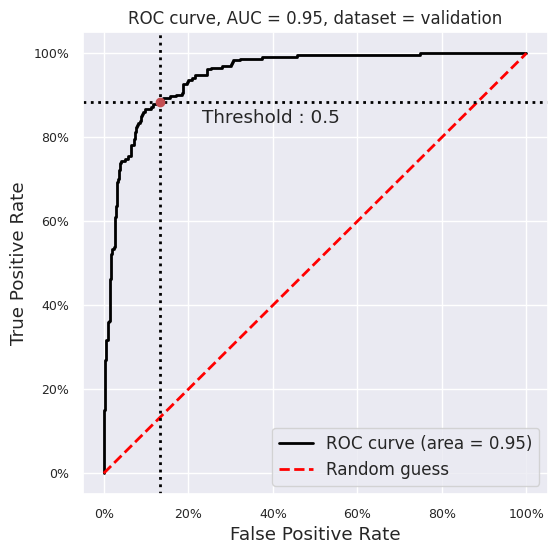

In [189]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

Some of the Correctly Predicted Classes

In [210]:
correct = np.nonzero(predictions.flatten() == y_test)[0]
incorrect = np.nonzero(predictions.flatten() != y_test)[0]

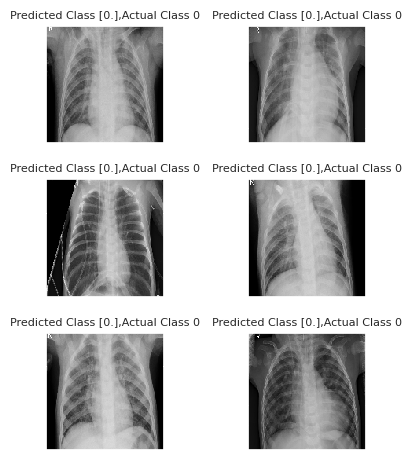

In [215]:
i = 0
# TODO(pinolej): use fig, axs = plt.subplots(2, 2, figsize=(15, 15)) to increase figsize
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=8)
    plt.tight_layout()
    i += 1

Some of the Incorrectly Predicted Classes

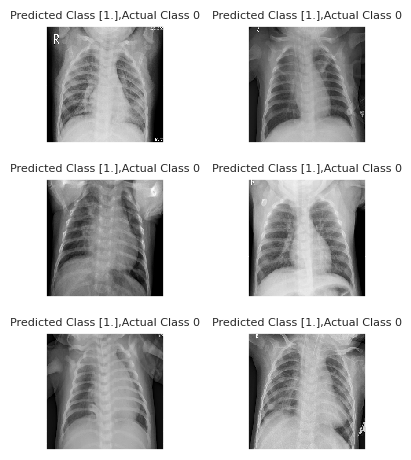

In [213]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]), fontsize=8)
    plt.tight_layout()
    i += 1

# Integrated Gradients

[New] Inspired from:

*  https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

[Old] Inspired from:

*  Main repository: https://github.com/ankurtaly/Integrated-Gradients/tree/master
*  ig_inception notebook: https://github.com/ankurtaly/Integrated-Gradients/blob/master/ig_inception.ipynb


In [220]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
model_example = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model_example.build([None, 224, 224, 3])
model_example.summary()

In [221]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [222]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [225]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [226]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

3954129/3954129 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
802859/802859 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


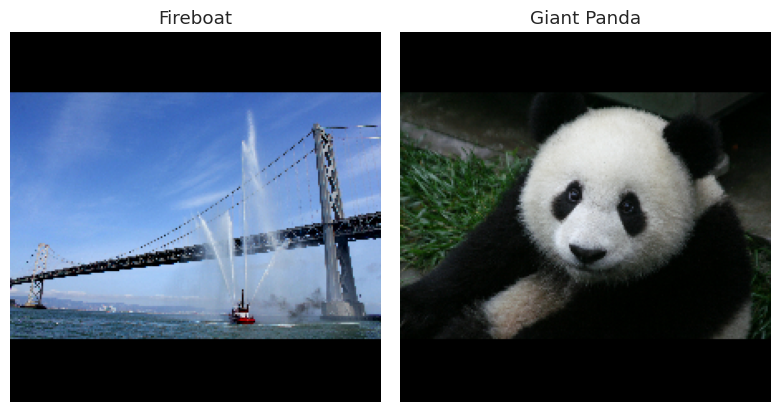

In [227]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [ ]:
img_name_tensors.keys()

{'Fireboat': <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0.,

In [228]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

In [ ]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

# Appendix

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l1_loss(self, w):
      return torch.abs(w).sum()

# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss